In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import math

%matplotlib inline

In [3]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
sub =  pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df_train.drop('Id', axis = 1 , inplace = True)
df_test.drop('Id', axis = 1 , inplace = True)
df_train.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

## Data preparing

In [6]:
CATEGORICAL_FEATURES_NAMES = []
NUMERIC_FEATURES_NAMES = []


for i, dtype in enumerate(df_train.dtypes):
    if dtype == 'float64' or dtype == 'int64':
        NUMERIC_FEATURES_NAMES.append(df_train.dtypes.index[i])
    elif dtype == 'object':
        CATEGORICAL_FEATURES_NAMES.append(df_train.dtypes.index[i])
print("numeric features : ", NUMERIC_FEATURES_NAMES)
print("categorical features : ", CATEGORICAL_FEATURES_NAMES)

numeric features :  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
categorical features :  ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu

In [7]:
CATEGORICAL_FEATURES_NAMES.append('MSSubClass')
NUMERIC_FEATURES_NAMES.remove('MSSubClass')
NUMERIC_FEATURES_NAMES.remove('SalePrice')
TARGET_FEATURE_NAME = 'SalePrice' 

Text(0.5, 1.0, 'SalePrice distribution')

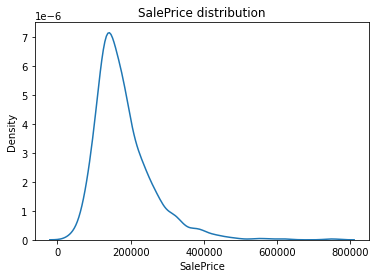

In [8]:
 sns.kdeplot(data = df_train[TARGET_FEATURE_NAME]).set_title('SalePrice distribution')

In [9]:
NEED_TO_BE_LOGGED_FEATURES_NAMES = []
NEED_TO_BE_LOGGED_FEATURES_NAMES.append('SalePrice')

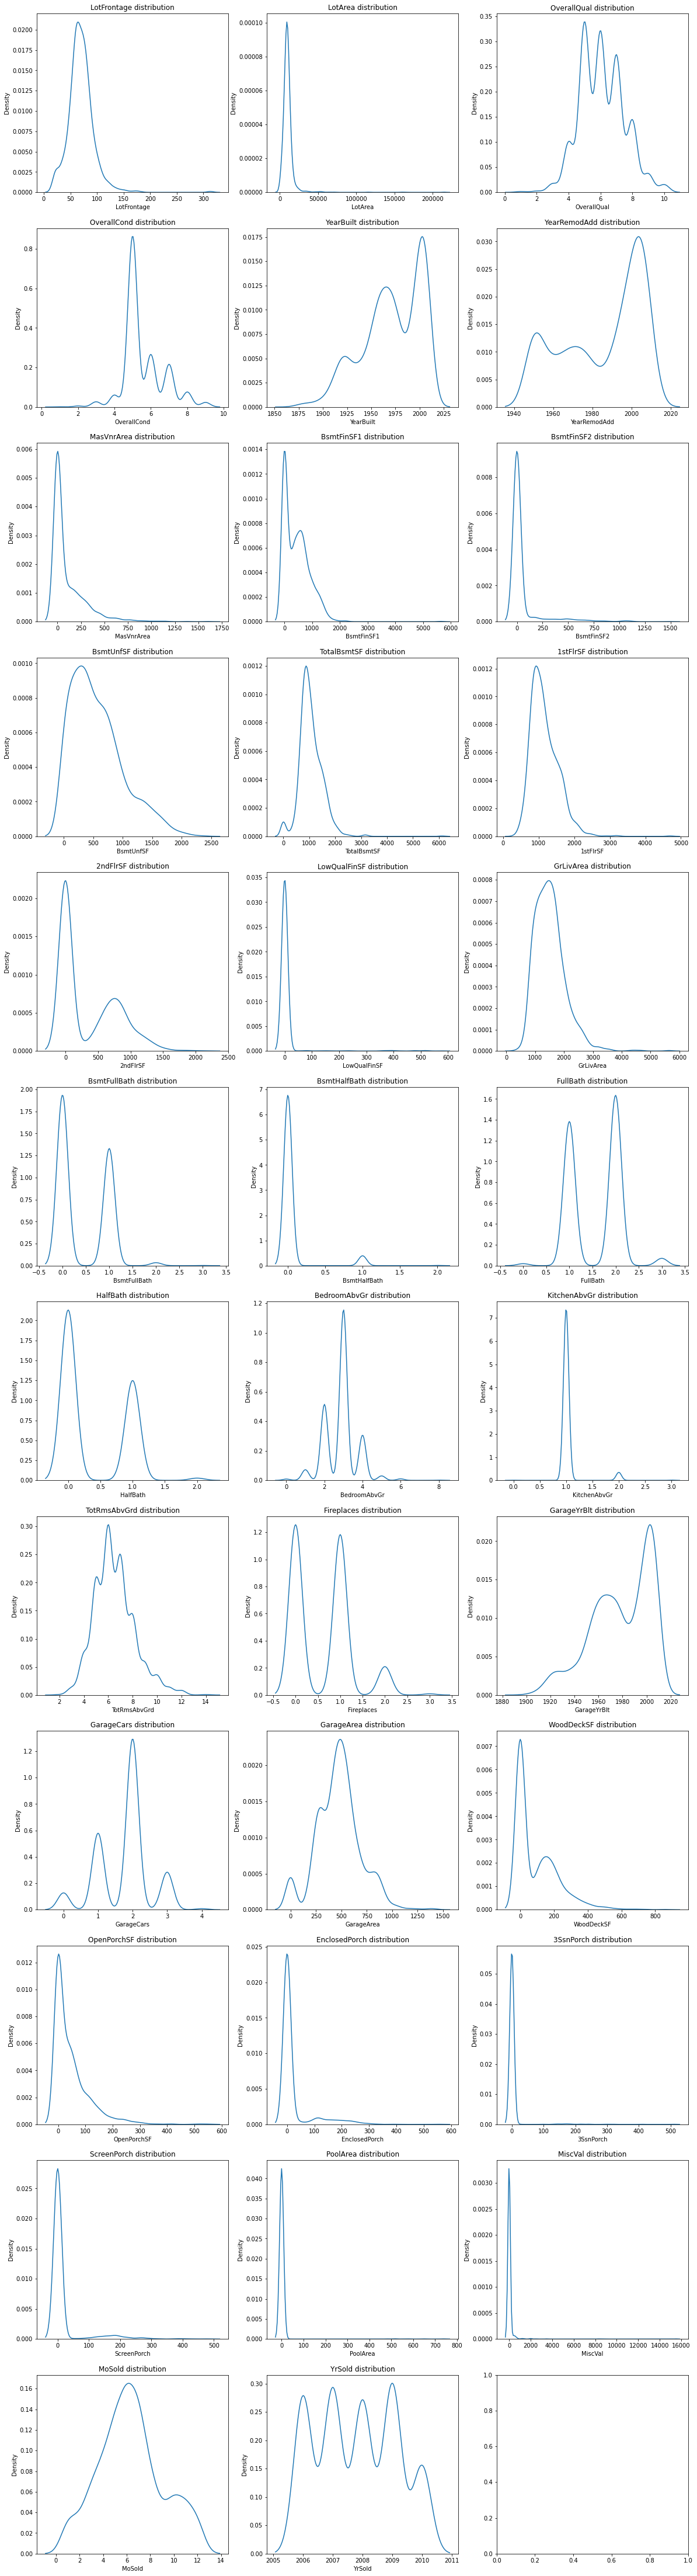

In [10]:
def show_numeric_distribution (data = None, FEATURES_NAME = None, target = None, row = 0, col = 0, figsize = (18, 18), ):

    fig, ax = plt.subplots(row,col, figsize = figsize)
    for i, feature in enumerate( FEATURES_NAME):
        sns.kdeplot(data = data[feature], ax = ax[math.floor(i/col), i%col]).set_title(f'{feature} distribution')
    fig.show()

show_numeric_distribution(data = df_train, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
                      row =  len(NUMERIC_FEATURES_NAMES)//3 + 1, col = 3, figsize = (20, 80)) 

In [16]:
for feature in NUMERIC_FEATURES_NAMES:
    if abs(df_train[feature].skew()) > 0.5:
        NEED_TO_BE_LOGGED_FEATURES_NAMES.append(feature)
    

In [17]:
NEED_TO_BE_LOGGED_FEATURES_NAMES

['SalePrice',
 'LotFrontage',
 'LotArea',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'LotFrontage',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'HalfBath',
 'KitchenAbvGr',
 'GarageYrBlt',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [18]:
df_train_logged =  df_train
df_train[TARGET_FEATURE_NAME] = np.log1p(df_train[TARGET_FEATURE_NAME])
for features in NEED_TO_BE_LOGGED_FEATURES_NAMES : 
    df_train_logged[features] = np.log1p(df_train[features])

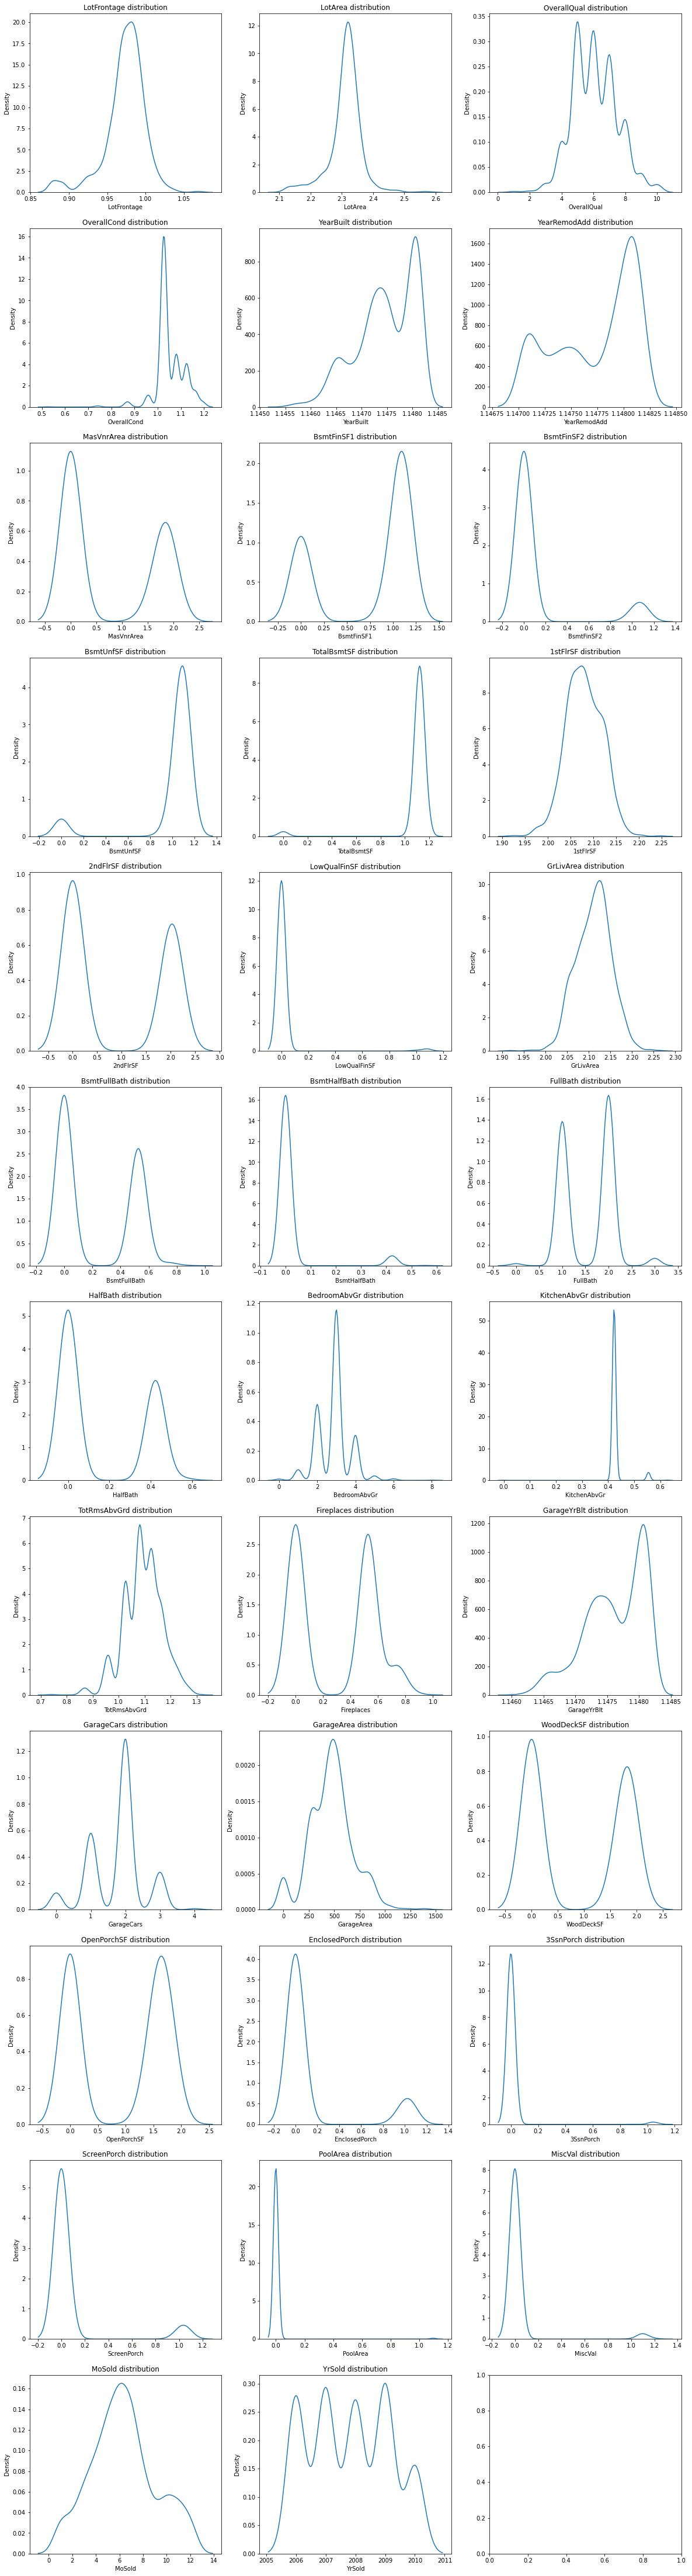

In [19]:
show_numeric_distribution(data = df_train_logged, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
                      row =  len(NUMERIC_FEATURES_NAMES)//3 + 1, col = 3, figsize = (20, 80)) 

Text(0.5, 1.0, 'SalePrice distribution')

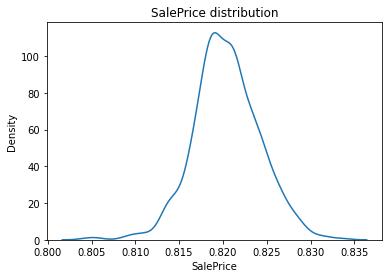

In [20]:
 sns.kdeplot(data = df_train[TARGET_FEATURE_NAME]).set_title('SalePrice distribution')

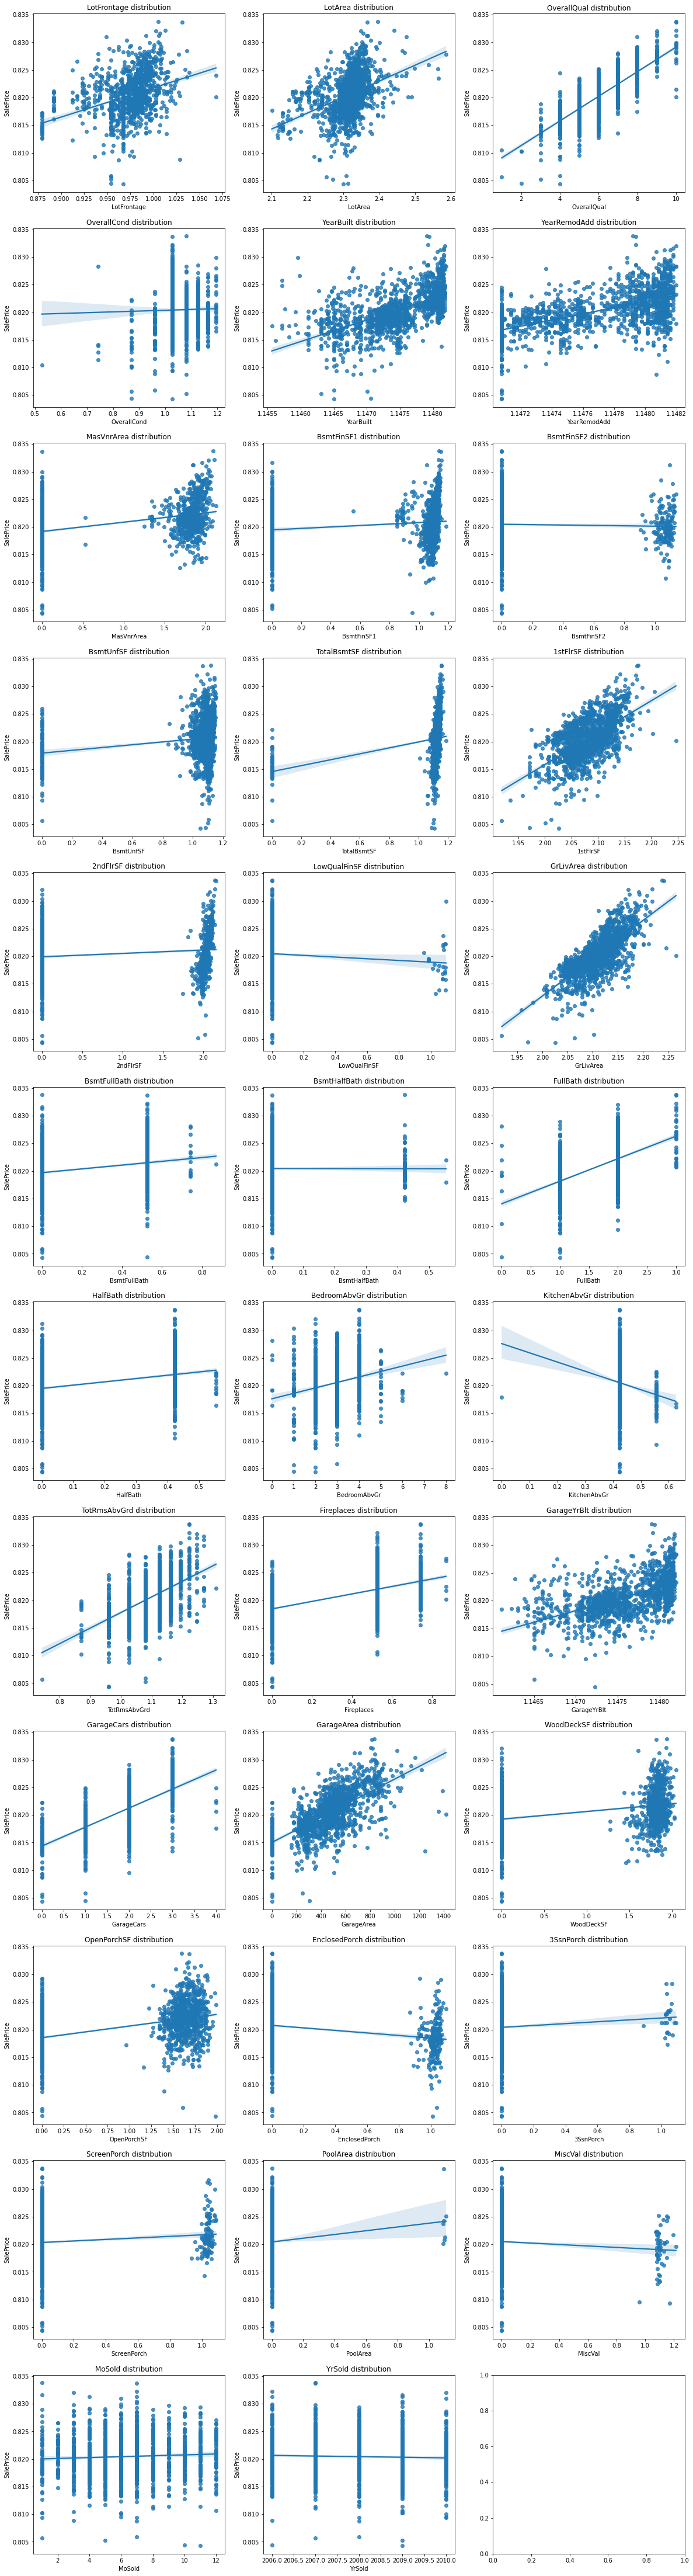

In [21]:
def show_regression_plots (data = None, FEATURES_NAME = None, target = None, row = 0, col = 0, figsize = (18, 18), ):

    fig, ax = plt.subplots(row,col, figsize = figsize)
    for i, feature in enumerate( FEATURES_NAME):
        sns.regplot(x = feature, y = target ,data = data, ax = ax[math.floor(i/col), i%col]).set_title(f'{feature} distribution')
    fig.show()

show_regression_plots(data = df_train_logged, target = TARGET_FEATURE_NAME, FEATURES_NAME = NUMERIC_FEATURES_NAMES,\
                      row =  len(NUMERIC_FEATURES_NAMES)//3 + 1 , col = 3, figsize = (20, 80)) 

In [22]:
df_train[TARGET_FEATURE_NAME] = np.log1p(df_train[TARGET_FEATURE_NAME])

In [23]:

HAVE_NA_FEATURES=df_train_logged.isna().sum().sort_values(ascending = False)[0:19] 
print(HAVE_NA_FEATURES)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


In [24]:
df_train[HAVE_NA_FEATURES.index].describe()

,LotFrontage,GarageYrBlt,MasVnrArea
count,1201.000000,1379.000000,1452.000000
mean,0.973353,1.147611,0.740607
std,0.026403,0.000463,0.899850
min,0.879129,1.146115,0.000000
25%,0.966273,1.147286,0.000000
50%,0.977552,1.147643,0.000000
75%,0.987819,1.148050,1.811234
max,1.067965,1.148197,2.125655


In [25]:
for feature in HAVE_NA_FEATURES.index: 
    print(feature)
    df_train[feature].fillna(df_train[feature].mode()[0], inplace = True)

PoolQC
MiscFeature
Alley
Fence
FireplaceQu
LotFrontage
GarageYrBlt
GarageCond
GarageType
GarageFinish
GarageQual
BsmtExposure
BsmtFinType2
BsmtCond
BsmtQual
BsmtFinType1
MasVnrArea
MasVnrType
Electrical


In [26]:
for feature in HAVE_NA_FEATURES.index: 
    print(feature)
    df_test[feature].fillna(df_test[feature].mode()[0], inplace = True)

PoolQC
MiscFeature
Alley
Fence
FireplaceQu
LotFrontage
GarageYrBlt
GarageCond
GarageType
GarageFinish
GarageQual
BsmtExposure
BsmtFinType2
BsmtCond
BsmtQual
BsmtFinType1
MasVnrArea
MasVnrType
Electrical


In [27]:
df_train['GarageCond'].mode()

0    TA
dtype: object

In [29]:
df_train.isna().sum().sum()

0

In [30]:
def get_dummy (df_features , CATEGORICAL_FEATURES_NAME):
    for features in CATEGORICAL_FEATURES_NAME:
        df_features[features] = df_features[features].astype(str)
    df_features_processed = pd.get_dummies(df_features ,CATEGORICAL_FEATURES_NAME)
    return df_features_processed

df_train_processed = get_dummy(df_train, CATEGORICAL_FEATURES_NAMES)
df_test_processed = get_dummy(df_test, CATEGORICAL_FEATURES_NAMES)

In [31]:
!pip install pycaret

     |████████████████████████████████| 301 kB 888 kB/s            
     |████████████████████████████████| 6.8 MB 14.2 MB/s            
     |████████████████████████████████| 636 kB 58.2 MB/s            
     |████████████████████████████████| 114 kB 65.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 16.5 MB 44.6 MB/s            
     |████████████████████████████████| 167 kB 31.5 MB/s            
     |████████████████████████████████| 25.9 MB 35.2 MB/s            
     |████████████████████████████████| 10.4 MB 53.4 MB/s            
     |████████████████████████████████| 24.2 MB 52.6 MB/s            
     |████████████████████████████████| 184 kB 62.6 MB/s            
     |████████████████████████████████| 1.0 MB 49.2 MB/s            
     |████████████████████████████████| 271 kB 63.1 MB/s            
     |████████████████████████████████| 14.8 MB 44.3 MB/s            
     |████████████████████████████████| 79 kB 6.3 MB/s    

In [ ]:
# !pip uninstall scikit-learn -y
# !pip install scikit-learn

In [ ]:
# !pip install scikit-learn

In [ ]:
# !conda update sklearn -y

In [ ]:
# !pip uninstall -v scikit-learn -y

# !pip install -v scikit-learn -y

In [32]:

from scipy.stats import norm, skew #for some statistics
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from pycaret.regression import *

ImportError: cannot import name '_raise_dep_warning_if_not_pytest' from 'sklearn.utils.deprecation' (/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py)

In [ ]:


s = setup(
          data = df_train, target= 'TARGET_FEATURE_NAME', train_size = 0.9,
          )

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, df_train[TARGET_FEATURE_NAME], scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))